In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
import folium
from branca.element import MacroElement
from jinja2 import Template
from IPython.display import IFrame
import webbrowser

from libpysal.weights import Queen
from esda.moran import Moran

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Charger les données sauvegardées
gdf_factors = gpd.read_file("gdf_factors.geojson")


In [2]:
gdf_factors.head()

,COM_geojson,DEP_geojson,DCOE_L_LIB,REGION,REG_geojson,DEPARTEMEN,EPCI,EPCI_CODE,demographie_niveau_vie,emploi_activite,...,services_publics,agriculture_elevage,industrie_agro_chimie,environnement_energie,risques_industriels,codgeo,canton,libgeo,dep,geometry
0,01001,01,L'Abergement-Clémenciat,Auvergne-Rhône-Alpes,84,Ain,Communauté de communes de la Dombes,200069193,3,4,...,3,2,0,2,0,01001,0108,L'Abergement-Clémenciat,01,"POLYGON ((4.92627 46.12005, 4.93106 46.12087, ..."
1,01002,01,L'Abergement-de-Varey,Auvergne-Rhône-Alpes,84,Ain,Communauté de communes de la Plaine de l'Ain,240100883,3,3,...,1,3,0,3,0,01002,0101,L'Abergement-de-Varey,01,"POLYGON ((5.43009 45.98276, 5.43444 45.98435, ..."
2,01004,01,Ambérieu-en-Bugey,Auvergne-Rhône-Alpes,84,Ain,Communauté de communes de la Plaine de l'Ain,240100883,4,4,...,4,2,4,2,0,01004,0101,Ambérieu-en-Bugey,01,"POLYGON ((5.38619 45.93093, 5.39427 45.9399, 5..."
3,01005,01,Ambérieux-en-Dombes,Auvergne-Rhône-Alpes,84,Ain,Communauté de communes Dombes Saône Vallée,200042497,3,3,...,2,0,0,2,0,01005,0122,Ambérieux-en-Dombes,01,"POLYGON ((4.89558 45.97991, 4.91891 45.9824, 4..."
4,01006,01,Ambléon,Auvergne-Rhône-Alpes,84,Ain,Communauté de communes Bugey Sud,200040350,3,4,...,2,0,0,4,0,01006,0104,Ambléon,01,"POLYGON ((5.61486 45.73464, 5.6114 45.74897, 5..."


In [3]:
# Étape 1 : Nettoyage des géométries
gdf_factors = gdf_factors[gdf_factors.geometry.notnull()]
gdf_factors = gdf_factors[gdf_factors.is_valid]

# Étape 2 : Supprimer les géométries de type Point ou LineString si présentes
gdf_factors = gdf_factors[gdf_factors.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]

# Étape 3 : Sélection des colonnes numériques avec variance non nulle
numeric_columns = gdf_factors.select_dtypes(include='number').columns
numeric_columns = [col for col in numeric_columns if gdf_factors[col].std() > 0]

# Étape 4 : Création de la matrice de voisinage spatiale
w = Queen.from_dataframe(gdf_factors, use_index=True)
w.transform = 'r'

# Étape 5 : Calcul de Moran's I pour chaque facteur
results = []
for col in numeric_columns:
    try:
        moran = Moran(gdf_factors[col], w)
        results.append({
            'facteur': col,
            "Moran's I": round(moran.I, 4),
            'p-value': round(moran.p_sim, 4)
        })
    except Exception as e:
        results.append({
            'facteur': col,
            "Moran's I": None,
            'p-value': None,
            'erreur': str(e)
        })

# Résultats
moran_df = pd.DataFrame(results)
print(moran_df)


/opt/conda/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 27 disconnected components.
 There are 21 islands with ids: 1775, 3103, 5561, 7298, 10352, 10353, 10354, 10415, 10599, 10772, 14662, 17634, 18880, 20571, 20587, 20588, 20589, 20590, 23363, 26753, 32689.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 1775, ' is an island (no neighbors)')
('WARNING: ', 3103, ' is an island (no neighbors)')
('WARNING: ', 5561, ' is an island (no neighbors)')
('WARNING: ', 7298, ' is an island (no neighbors)')
('WARNING: ', 10352, ' is an island (no neighbors)')
('WARNING: ', 10353, ' is an island (no neighbors)')
('WARNING: ', 10354, ' is an island (no neighbors)')
('WARNING: ', 10415, ' is an island (no neighbors)')
('WARNING: ', 10599, ' is an island (no neighbors)')
('WARNING: ', 10772, ' is an island (no neighbors)')
('WARNING: ', 14662, ' is an island (no neighbors)')
('WARNING: ', 17634, ' is an island (no neighbors)')
('WARNING: ', 18880, ' is an island (no neighbors)')
('WARNING: ', 20571, ' is an island (no neighbors)')
('WARNING: ', 20587, ' is an island (no neighbors)')
('WARNING: ', 20588, ' is an island (no neighbors)')
('WARNING: ', 20589, ' is an island (no neighbors)')
('WARNING: ', 20590, ' is an island (no neighbors)')
('WARNING: ', 23363, ' is an island (no neighbors)

/tmp/ipykernel_109/3041553623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=moran_df.sort_values("Moran's I", ascending=False), x="Moran's I", y="facteur", palette="viridis")


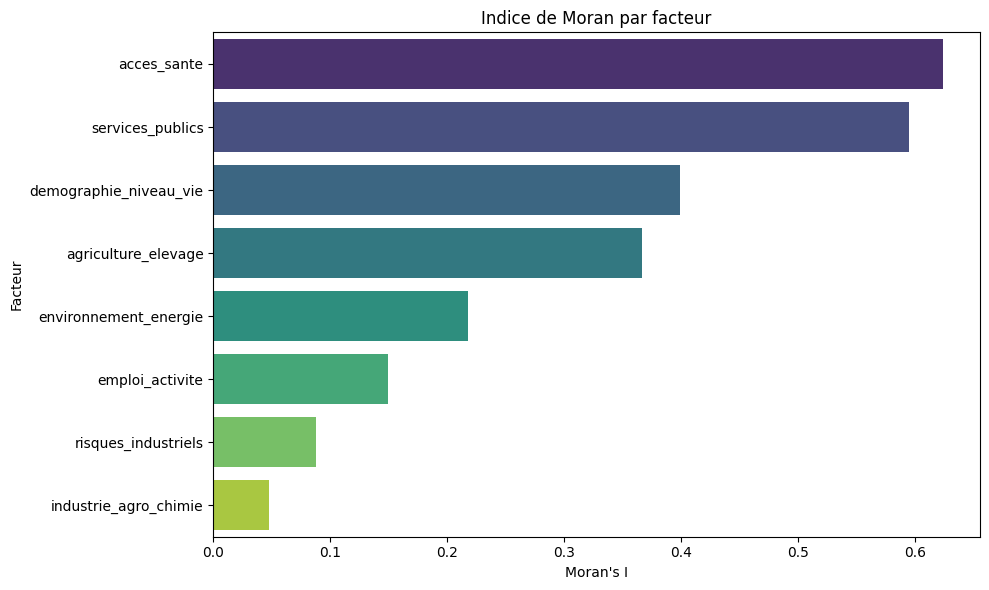

In [10]:
# Diagramme des indices de Moran
plt.figure(figsize=(10, 6))
sns.barplot(data=moran_df.sort_values("Moran's I", ascending=False), x="Moran's I", y="facteur", palette="viridis")
plt.title("Indice de Moran par facteur")
plt.xlabel("Moran's I")
plt.ylabel("Facteur")
plt.tight_layout()
plt.savefig("moran_barplot.png")
plt.show()

In [11]:
# Regression + Random Forest

Colonnes dans gdf_factors : ['COM_geojson', 'DEP_geojson', 'DCOE_L_LIB', 'REGION', 'REG_geojson', 'DEPARTEMEN', 'EPCI', 'EPCI_CODE', 'demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels', 'codgeo', 'canton', 'libgeo', 'dep', 'geometry']
facteurs_valides : ['demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels']

Modèle pour cible : demographie_niveau_vie avec features : ['emploi_activite', 'acces_sante', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels']
Données valides (sans NaN) pour demographie_niveau_vie : (34827, 8)
Meilleur modèle pour demographie_niveau_vie : HistGradientBoosting avec R² = 0.3038


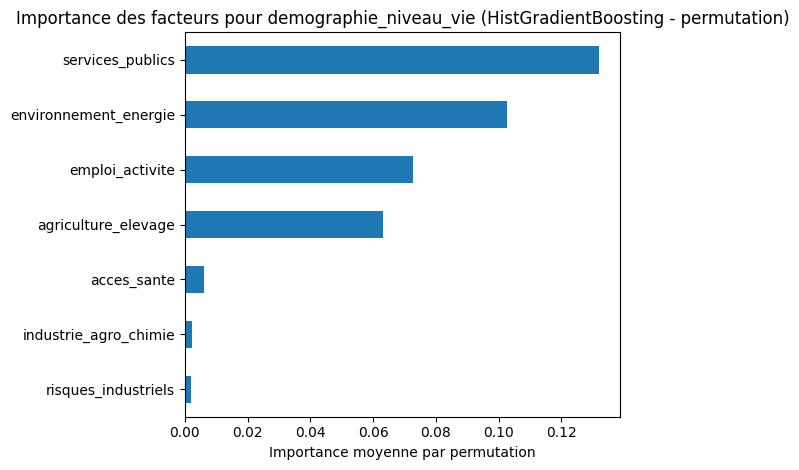


Modèle pour cible : emploi_activite avec features : ['demographie_niveau_vie', 'acces_sante', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels']
Données valides (sans NaN) pour emploi_activite : (34827, 8)
Meilleur modèle pour emploi_activite : HistGradientBoosting avec R² = 0.0657


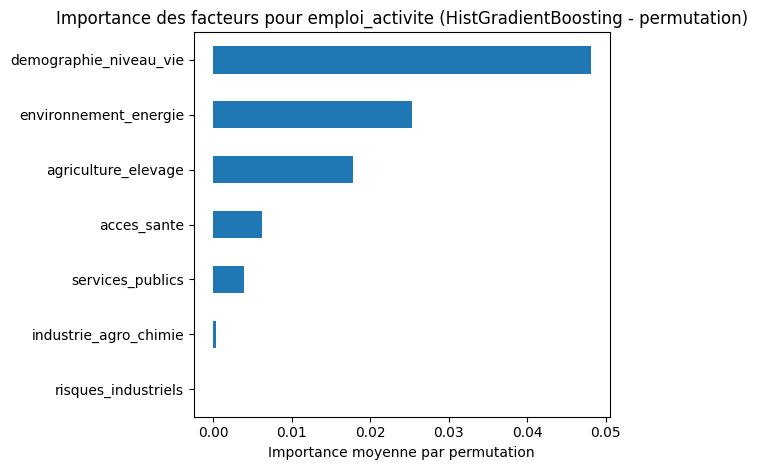


Modèle pour cible : acces_sante avec features : ['demographie_niveau_vie', 'emploi_activite', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels']
Données valides (sans NaN) pour acces_sante : (34827, 8)
Meilleur modèle pour acces_sante : HistGradientBoosting avec R² = 0.2110


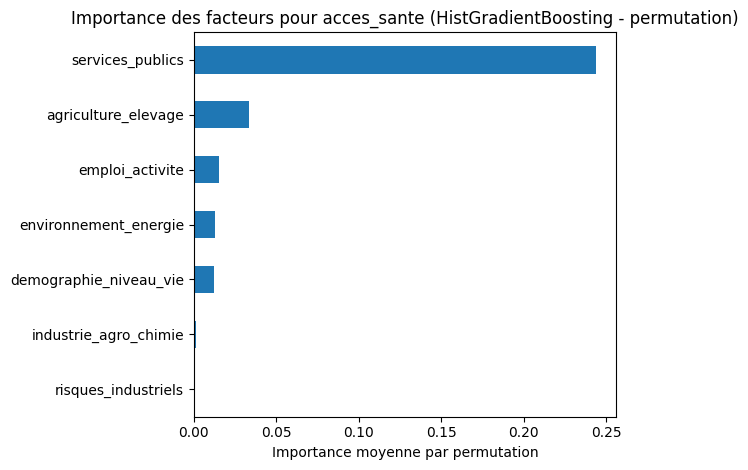


Modèle pour cible : services_publics avec features : ['demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels']
Données valides (sans NaN) pour services_publics : (34827, 8)
Meilleur modèle pour services_publics : HistGradientBoosting avec R² = 0.3708


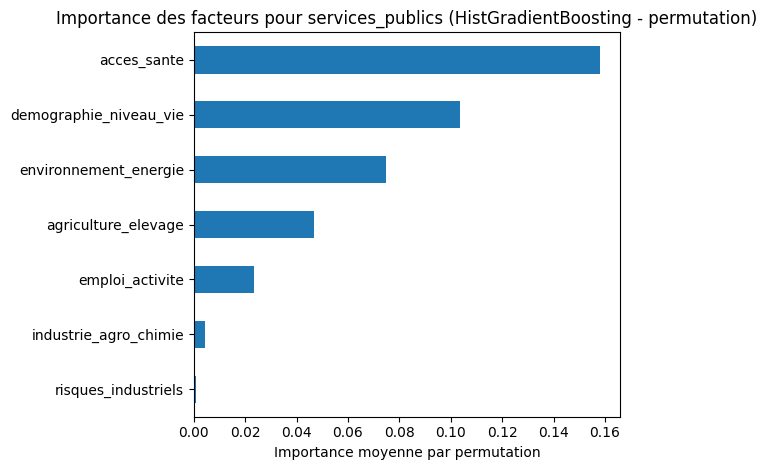


Modèle pour cible : agriculture_elevage avec features : ['demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'services_publics', 'industrie_agro_chimie', 'environnement_energie', 'risques_industriels']
Données valides (sans NaN) pour agriculture_elevage : (34827, 8)
Meilleur modèle pour agriculture_elevage : HistGradientBoosting avec R² = 0.0614


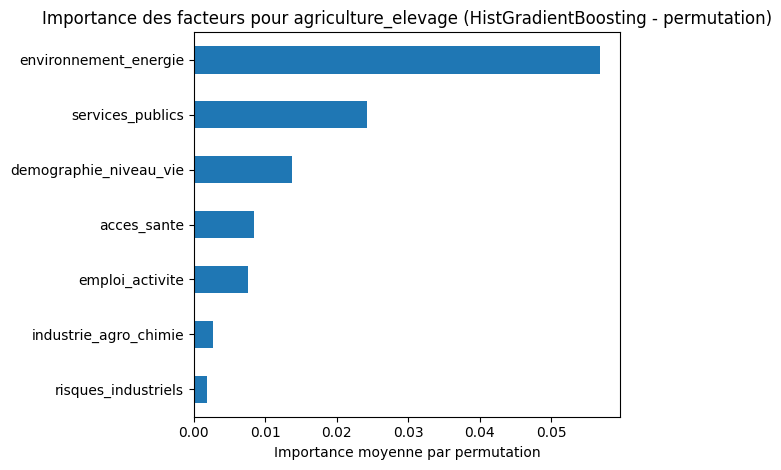


Modèle pour cible : industrie_agro_chimie avec features : ['demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'services_publics', 'agriculture_elevage', 'environnement_energie', 'risques_industriels']
Données valides (sans NaN) pour industrie_agro_chimie : (34827, 8)
Meilleur modèle pour industrie_agro_chimie : HistGradientBoosting avec R² = 0.0697


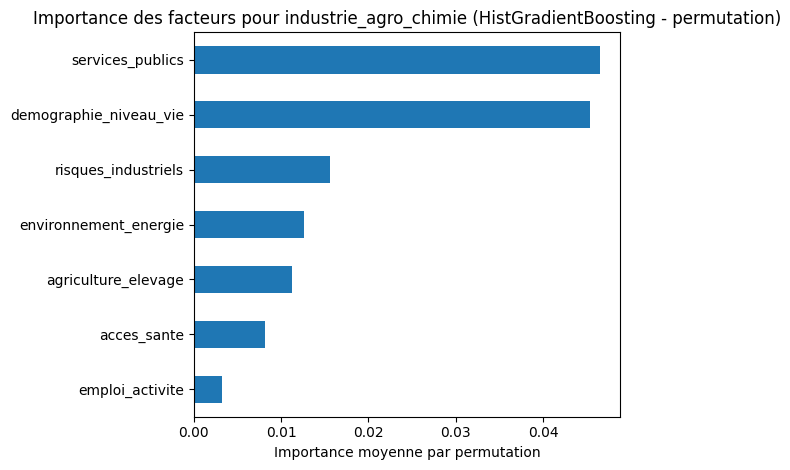


Modèle pour cible : environnement_energie avec features : ['demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'risques_industriels']
Données valides (sans NaN) pour environnement_energie : (34827, 8)
Meilleur modèle pour environnement_energie : HistGradientBoosting avec R² = 0.0346


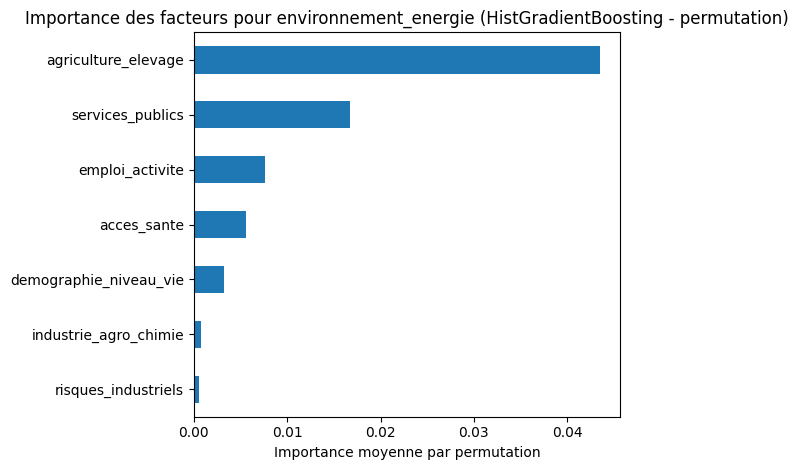


Modèle pour cible : risques_industriels avec features : ['demographie_niveau_vie', 'emploi_activite', 'acces_sante', 'services_publics', 'agriculture_elevage', 'industrie_agro_chimie', 'environnement_energie']
Données valides (sans NaN) pour risques_industriels : (34827, 8)
Meilleur modèle pour risques_industriels : HistGradientBoosting avec R² = 0.0702


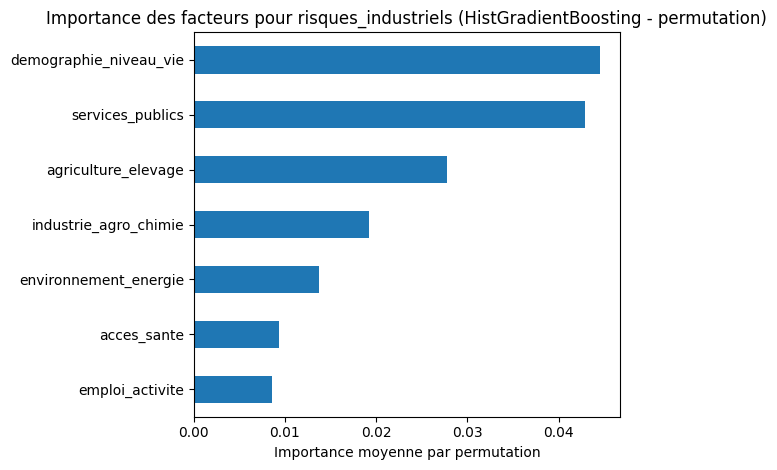


Résumé des scores R² et meilleurs modèles :
                    Cible  R2_LinReg  R2_RandomForest  \
0  demographie_niveau_vie   0.200579         0.271422   
1         emploi_activite   0.045596         0.032258   
2             acces_sante   0.178495         0.165746   
3        services_publics   0.299719         0.338869   
4     agriculture_elevage   0.049235         0.021116   
5   industrie_agro_chimie   0.043146        -0.021019   
6   environnement_energie   0.032846        -0.013200   
7     risques_industriels   0.040465        -0.009774   

   R2_HistGradientBoosting            Best_Model   Best_R2  
0                 0.303820  HistGradientBoosting  0.303820  
1                 0.065682  HistGradientBoosting  0.065682  
2                 0.211000  HistGradientBoosting  0.211000  
3                 0.370819  HistGradientBoosting  0.370819  
4                 0.061369  HistGradientBoosting  0.061369  
5                 0.069676  HistGradientBoosting  0.069676  
6             

In [5]:


facteurs = [
    'demographie_niveau_vie', 'emploi_activite', 'acces_sante',
    'services_publics', 'agriculture_elevage', 'industrie_agro_chimie',
    'environnement_energie', 'risques_industriels'
]

print("Colonnes dans gdf_factors :", gdf_factors.columns.tolist())

facteurs_valides = [f for f in facteurs if f in gdf_factors.columns]
print("facteurs_valides :", facteurs_valides)

results = []

for target in facteurs_valides:
    features = [f for f in facteurs_valides if f != target]
    print(f"\nModèle pour cible : {target} avec features : {features}")

    X = gdf_factors[features]
    y = gdf_factors[target]

    data = pd.concat([X, y], axis=1).dropna()
    print(f"Données valides (sans NaN) pour {target} :", data.shape)

    if data.empty:
        print(f"Aucune donnée valide pour {target}, on passe à la cible suivante.")
        continue

    X_clean = data[features]
    y_clean = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, random_state=42)

    # Entraînement des modèles
    lr = LinearRegression().fit(X_train, y_train)
    rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
    hgb = HistGradientBoostingRegressor(random_state=42).fit(X_train, y_train)

    # Prédictions et scores R²
    r2_lr = r2_score(y_test, lr.predict(X_test))
    r2_rf = r2_score(y_test, rf.predict(X_test))
    r2_hgb = r2_score(y_test, hgb.predict(X_test))

    # Déterminer le meilleur modèle
    scores = {'LinReg': r2_lr, 'RandomForest': r2_rf, 'HistGradientBoosting': r2_hgb}
    best_model_name = max(scores, key=scores.get)
    best_r2 = scores[best_model_name]

    print(f"Meilleur modèle pour {target} : {best_model_name} avec R² = {best_r2:.4f}")

    results.append({
        'Cible': target,
        'R2_LinReg': r2_lr,
        'R2_RandomForest': r2_rf,
        'R2_HistGradientBoosting': r2_hgb,
        'Best_Model': best_model_name,
        'Best_R2': best_r2
    })

    # Affichage de l'importance des variables selon le meilleur modèle
    if best_model_name == 'LinReg':
        # Importance via valeur absolue des coefficients
        coefs = pd.Series(abs(lr.coef_), index=X_train.columns).sort_values()
        coefs.plot(kind='barh', title=f"Importance des facteurs pour {target} ({best_model_name})")
        plt.xlabel("Valeur absolue des coefficients")
        plt.tight_layout()
        plt.show()

    elif best_model_name == 'RandomForest':
        # Permutation importance pour RF
        result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_test.columns).sort_values()
        importances.plot(kind='barh', title=f"Importance des facteurs pour {target} ({best_model_name} - permutation)")
        plt.xlabel("Importance moyenne par permutation")
        plt.tight_layout()
        plt.show()

    else:  # HistGradientBoosting
        result = permutation_importance(hgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_test.columns).sort_values()
        importances.plot(kind='barh', title=f"Importance des facteurs pour {target} ({best_model_name} - permutation)")
        plt.xlabel("Importance moyenne par permutation")
        plt.tight_layout()
        plt.show()

if results:
    results_df = pd.DataFrame(results)
    print("\nRésumé des scores R² et meilleurs modèles :")
    print(results_df)
else:
    print("Aucun résultat à afficher (pas de données valides ou pas de facteurs valides).")



Cible : demographie_niveau_vie
Stacking R² test = 0.2868, CV R² = 0.2598


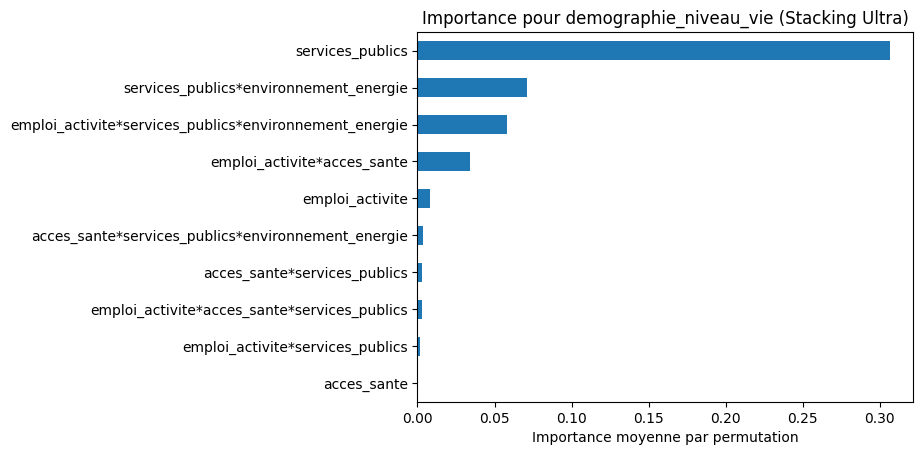


Cible : emploi_activite
Stacking R² test = 0.0628, CV R² = 0.0278


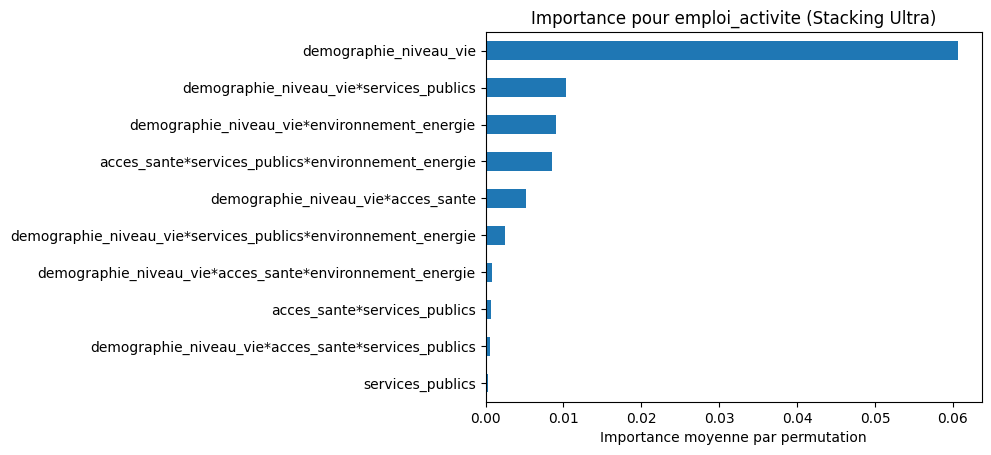


Cible : acces_sante
Stacking R² test = 0.2123, CV R² = 0.1461


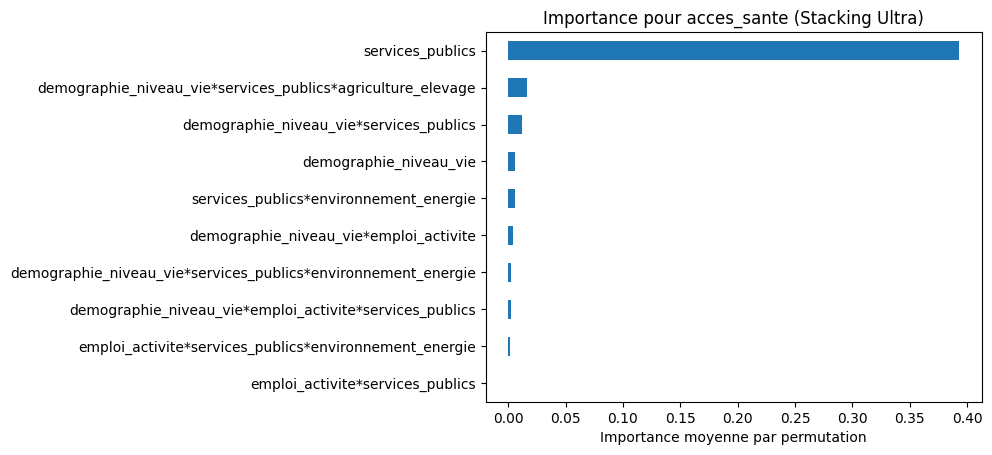


Cible : services_publics
Stacking R² test = 0.3677, CV R² = 0.3411


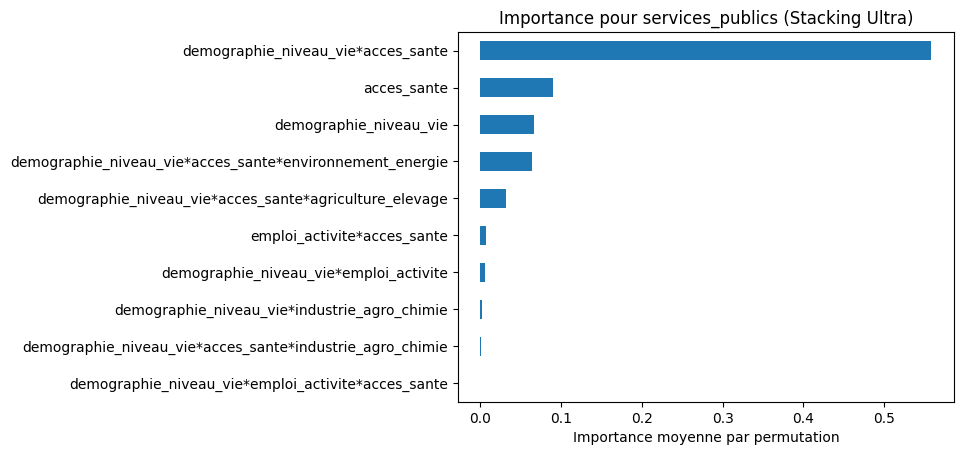


Cible : agriculture_elevage
Stacking R² test = 0.0635, CV R² = 0.0121


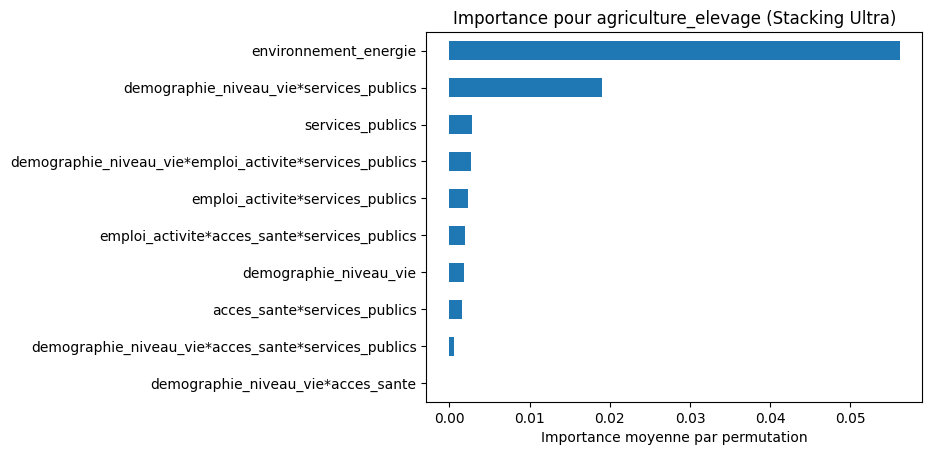


Cible : industrie_agro_chimie
Stacking R² test = 0.0559, CV R² = 0.0641


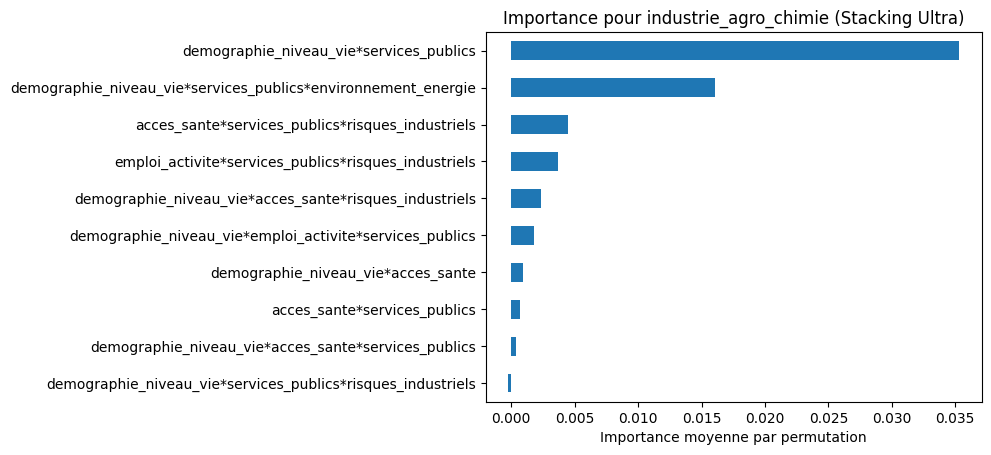


Cible : environnement_energie
Stacking R² test = 0.0389, CV R² = 0.0193


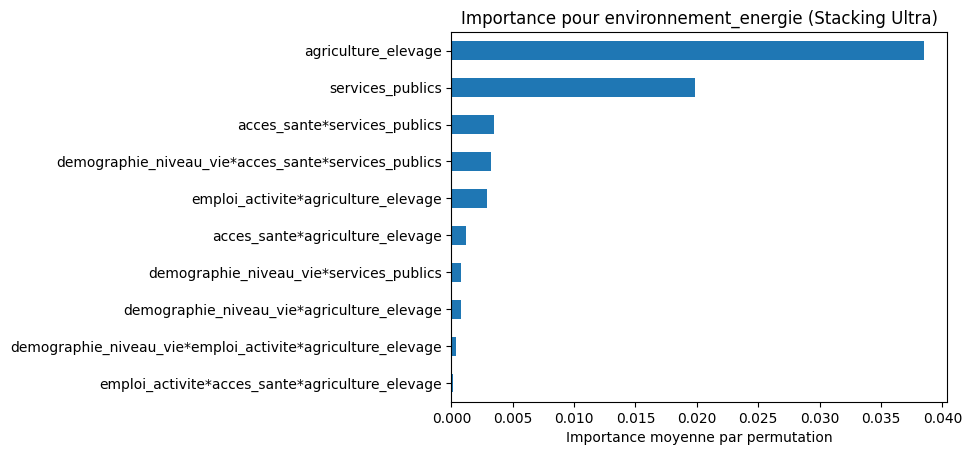


Cible : risques_industriels
Stacking R² test = 0.0558, CV R² = 0.0511


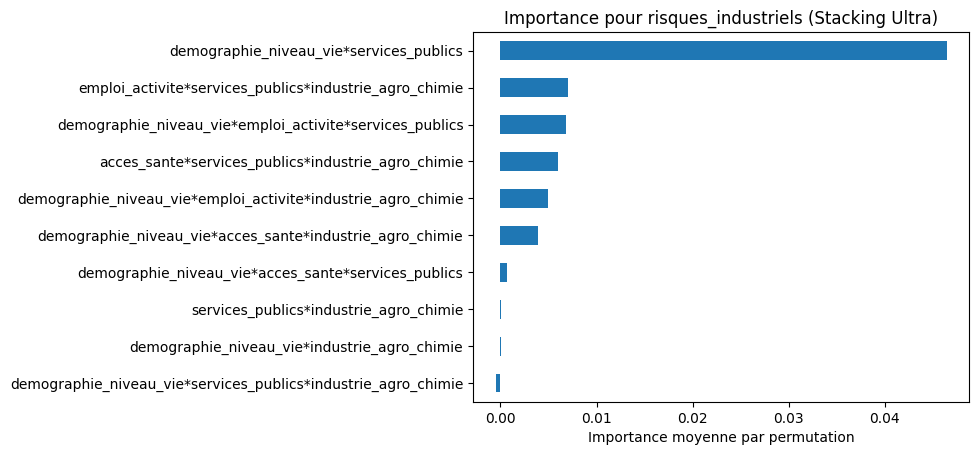


Résumé des R² et meilleurs modèles :
                    Cible   R2_Test     R2_CV Best_Model
0  demographie_niveau_vie  0.286779  0.259774   Stacking
1         emploi_activite  0.062814  0.027813   Stacking
2             acces_sante  0.212256  0.146127   Stacking
3        services_publics  0.367664  0.341064   Stacking
4     agriculture_elevage  0.063538  0.012098   Stacking
5   industrie_agro_chimie  0.055909  0.064078   Stacking
6   environnement_energie  0.038861  0.019264   Stacking
7     risques_industriels  0.055813  0.051105   Stacking


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

# XGBoost et CatBoost si installés
try:
    from xgboost import XGBRegressor
    xgb_installed = True
except ImportError:
    xgb_installed = False

try:
    from catboost import CatBoostRegressor
    catboost_installed = True
except ImportError:
    catboost_installed = False

facteurs = [
    'demographie_niveau_vie', 'emploi_activite', 'acces_sante',
    'services_publics', 'agriculture_elevage', 'industrie_agro_chimie',
    'environnement_energie', 'risques_industriels'
]

facteurs_valides = [f for f in facteurs if f in gdf_factors.columns]
results = []

for target in facteurs_valides:
    features = [f for f in facteurs_valides if f != target]
    print(f"\nCible : {target}")

    X = gdf_factors[features].copy()
    y = gdf_factors[target]

    # 1️⃣ Imputation KNN
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # 2️⃣ Création d'interactions simples et triples
    cols = X_imputed.columns.tolist()
    # Interactions simples
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            X_imputed[f'{cols[i]}*{cols[j]}'] = X_imputed[cols[i]] * X_imputed[cols[j]]
    # Interactions triples (si dataset pas trop petit)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            for k in range(j+1, len(cols)):
                X_imputed[f'{cols[i]}*{cols[j]}*{cols[k]}'] = X_imputed[cols[i]] * X_imputed[cols[j]] * X_imputed[cols[k]]

    # 3️⃣ Transformations log1p et sqrt
    for col in X_imputed.columns:
        if (X_imputed[col] > 0).all():
            X_imputed[f'log1p_{col}'] = np.log1p(X_imputed[col])
            X_imputed[f'sqrt_{col}'] = np.sqrt(X_imputed[col])

    # 4️⃣ Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # 5️⃣ Sélection automatique des 10 meilleures features
    k_best = min(10, X_scaled.shape[1])
    selector = SelectKBest(score_func=f_regression, k=k_best)
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = [X_imputed.columns[i] for i, s in enumerate(selector.get_support()) if s]

    # 6️⃣ Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42
    )

    # 7️⃣ Définition des modèles de base pour stacking
    estimators = [
        ('rf', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=5)),
        ('hgb', HistGradientBoostingRegressor(random_state=42, max_iter=200))
    ]
    if xgb_installed:
        estimators.append(('xgb', XGBRegressor(random_state=42, n_estimators=200, max_depth=5, learning_rate=0.1)))
    if catboost_installed:
        estimators.append(('cat', CatBoostRegressor(random_state=42, iterations=200, verbose=0)))

    # 8️⃣ Stacking
    stack_model = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        n_jobs=-1
    )
    stack_model.fit(X_train, y_train)

    # 9️⃣ Évaluation
    y_pred = stack_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    cv_r2 = cross_val_score(stack_model, X_selected, y, cv=5, scoring='r2').mean()
    print(f"Stacking R² test = {test_r2:.4f}, CV R² = {cv_r2:.4f}")

    results.append({
        'Cible': target,
        'R2_Test': test_r2,
        'R2_CV': cv_r2,
        'Best_Model': 'Stacking'
    })

    # 10️⃣ Importance des variables
    perm = permutation_importance(stack_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    importances = pd.Series(perm.importances_mean, index=selected_features).sort_values()
    importances.plot(kind='barh', title=f"Importance pour {target} (Stacking Ultra)")
    plt.xlabel("Importance moyenne par permutation")
    plt.show()

# Résumé final
results_df = pd.DataFrame(results)
print("\nRésumé des R² et meilleurs modèles :")
print(results_df)
